In [1]:
import qiskit
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict
from operator import itemgetter
from scipy.optimize import minimize
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, execute, Aer
from qiskit.aqua.algorithms import NumPyEigensolver
from qiskit.quantum_info import Pauli
from qiskit.aqua.operators import op_converter
from qiskit.aqua.operators import WeightedPauliOperator


{(1, 2): Text(1.5, 1.5, '20.5'), (1, 3): Text(1.0, 0.5, '9.8')}

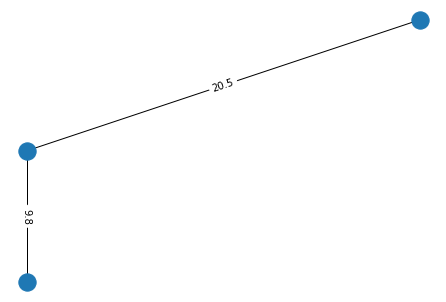

In [2]:
G=nx.Graph()
i=1
G.add_node(i,pos=(i,i))
G.add_node(2,pos=(2,2))
G.add_node(3,pos=(1,0))
G.add_edge(1,2,weight=20.5)
G.add_edge(1,3,weight=9.8)
pos=nx.get_node_attributes(G,'pos')
nx.draw(G,pos)
labels = nx.get_edge_attributes(G,'weight')
nx.draw_networkx_edge_labels(G,pos,edge_labels=labels)

In [3]:
def append_zz_term(qc,q1,q2,gamma):
    qc.cx(q1,q2)
    qc.rz(2*gamma,q2)
    qc.cx(q1,q2)


In [4]:
def get_cost_circuit(G,gamma):
    N=G.number_of_nodes()
    qc=QuantumCircuit(N,N)
    for i,j in G.edges():
        append_zz_term(qc,i,j,gamma)
    return qc
#print(get_cost_circuit(G,0.5))

In [5]:
def append_x_term(qc,q1,beta):
    qc.rx(2*beta,q1)

def get_mixer_operator(G,beta):
    N=G.number_of_nodes()
    qc=QuantumCircuit(N,N)
    for n in G.nodes():
        append_x_term(qc,n,beta)
    return qc

#print(get_mixer_operator(G,0.5))


In [6]:
def get_QAOA_circuit(G,beta,gamma):
    assert(len(beta)==len(gamma))
    N=G.number_of_nodes()
    qc=QuantumCircuit(N,N)
    qc.h(range(N))
    p=len(beta)
    #aplicamos las p rotaciones
    for i in range(p):
        qc=qc.compose(get_cost_circuit(G,gamma[i]))
        qc=qc.compose(get_mixer_operator(G,beta[i]))
    qc.barrier(range(N))
    qc.measure(range(N),range(N))
    return qc
    
print(get_QAOA_circuit(G,[0.5,0,6],[0.5,0,6]))    

        

CircuitError: 'Index out of range.'

In [ ]:
def invert_counts(counts):
    return {k[::-1] :v for k,v in counts.items()}

qc=get_QAOA_circuit(G,[0.5,0,6],[0.5,0,6])   
backend=Aer.get_backend('qasm_simulator')
job=execute(qc,backend)
result=job.result()
print(invert_counts(result.get_counts()))

In [ ]:
def maxcut_obj(x,G):
    cut=0
    for i,j in G.edges():
        if x[i]!=x[j]:
            cut = cut-1
    return cut
print(maxcut_obj("00011",G))

In [ ]:
def compute_maxcut_energy(counts,G):
    energy=0
    get_counts=0
    total_counts=0
    for meas, meas_count in counts.items():
        obj_for_meas=maxcut_obj(meas,G)
        energy+=obj_for_meas*meas_count
        total_counts+=meas_count
    return energy/total_counts

In [ ]:
def get_black_box_objective(G,p):
    backend=Aer.get_backend('qasm_simulator')
    def f(theta):
        beta=theta[:p]
        gamma=theta[p:]
        qc=get_QAOA_circuit(G,beta,gamma)
        counts=execute(qc,backend,seed_simulator=10).result().get_counts()
        return compute_maxcut_energy(invert_counts(counts),G)
    return f
p=5
obj=get_black_box_objective(G,p)
init_point=np.array([0.8,2.2,0.83,2.15,0.37,2.4,6.1,2.2,3.8,6.1])#([2,2,1,1,1,1,1,1,1,1])
res_sample=minimize(obj, init_point,method="COBYLA",options={"maxiter":2500,"disp":True})

res_sample
        

In [ ]:
from thirdParty.classical import rand_graph, classical, bitstring_to_path, calc_cost
from utils import mapeo_grafo

In [ ]:
cantidad_ciudades = 4
pesos, conexiones = None, None
mejor_camino = None
while not mejor_camino:
    pesos, conexiones = rand_graph(cantidad_ciudades)
    mejor_costo, mejor_camino = classical(pesos, conexiones, loop=False)
        

In [ ]:
G = mapeo_grafo(conexiones, pesos)

pos=nx.spring_layout(G)
nx.draw(G,pos)
labels = nx.get_edge_attributes(G,'weight')
nx.draw_networkx_edge_labels(G,pos,edge_labels=labels)


In [ ]:
G

In [ ]:
pos=nx.get_node_attributes(G,'weight')

In [ ]:
pos

In [ ]:
labels = nx.get_edge_attributes(G,'weight')

In [ ]:
labels

In [7]:
def funcion_costo(multiplicador_lagrange, cantidad_ciudades, pesos, conexiones ):
    N = G.number_of_nodes()
    N_square = N^2
    # restriccion 1
    for i in range(cantidad_ciudades):
        cur = sI(N_square) 
        for j in range(num_cities):
            cur -= D(i, j)  
        ret += cur**2
        
    

{(1, 2): 20.5, (1, 3): 9.8}

In [9]:
# retorna el indice de qubit por conversion al problema
def quibit_indice(i, l, N):
    return i * N + l


In [23]:
from qiskit.opflow import I, X, Y, Z

def sI(N_square):
    return I^N_square
    

In [22]:
def D(i, j):
    b = quibit_indice(alpha, j)
    return .5 * (sI(b) - sZ(b))

PauliOp(Pauli('I'), coeff=2.0)

In [43]:
print(((I^I) - (I^Z)).to_matrix())

[[0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 2.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 2.+0.j]]


In [17]:
qc = QuantumCircuit(2,2)

In [46]:
print((I^Z).to_matrix())

[[ 1.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j -1.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  1.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j -1.+0.j]]


In [53]:
(I,Z)

(PauliOp(Pauli('I'), coeff=1.0), PauliOp(Pauli('Z'), coeff=1.0))

In [54]:
I.exp_i()


PauliOp(Pauli('I'), coeff=1.0)

In [55]:
I.exp_i().to_operator()

AttributeError: 'PauliOp' object has no attribute 'to_operator'

/Users/nacho/opt/anaconda3/envs/ComputacionQuantica/lib/python3.9/site-packages/qiskit/quantum_info/operators/symplectic/pauli.py:187: DeprecationWarning: Initializing Pauli from `Pauli(label=l)` kwarg is deprecated as of version 0.17.0 and will be removed no earlier than 3 months after the release date. Use `Pauli(l)` instead.
  base_z, base_x, base_phase = self._from_label_deprecated(label)


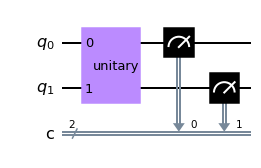

In [57]:
from qiskit.quantum_info.operators import Operator, Pauli
# Create an operator
XX = Operator(Pauli(label='XX'))

# Add to a circuit
circ = QuantumCircuit(2, 2)
circ.append(XX, [0, 1])
circ.measure([0,1], [0,1])
circ.draw('mpl')

In [97]:
a = Operator(0.5*Z)
a = 0.5*( Z)


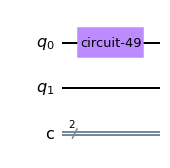

In [98]:
# Add to a circuit
circ = QuantumCircuit(2, 2)
circ.append(a, [0])
#circ.measure([0,1], [0,1])
circ.draw('mpl')

In [104]:
a = I - ( 0.5*(I+ Z))**2
a = Operator(a)

In [105]:
a.is_unitary()

False

In [76]:
print(I @ Z)

Z
